# pump probe analysis

## initialization

### loading libraries

In [1]:
import sys
import os
path_to_add = "../filter_masks/"
sys.path.append(path_to_add)
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import filter_masks
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from cycler import cycler
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import interactive
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor

### setting matplotlib display defaults

In [2]:
#default plot setting
mpl.rcParams['axes.prop_cycle'] = cycler(color='brgcmyk')
mpl.rcParams['figure.figsize'] = (8,8)
plt.rcParams['image.cmap'] = 'magma'
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
#mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 10

### loading data

In [3]:



#load data
experiment_run_name = "sxri0414run60"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("../small_h5_data/"+my_file,"r")

#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

#no built in type for weighted binnsed statistic, 
#might be able to use sum instead of mean (or average)
def weighted_binned_statistic(x,y,weights,bins,statistic):
    binned_weighted_statistic = binned_statistic_dd(x,y*weights,bins=[my_bins],statistic=average)
    binned_weights = binned_statistic_dd(x,1.0*weights,bins=[my_bins],statistic=average)
    
    return  binned_weighted_statistic.statistic/binned_weights.statistic

#make mask
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>300)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<1600)
#my_mask *=  (my_dict['ebeam/photon_energy']>913.75)
#my_mask *=  (my_dict['ebeam/photon_energy']<914.25)

#my_mask *=  (my_dict['timeToolOpal/uncertainty_cov']*pixel_to_femtosecond<0.0002)

../filter_masks/filter_masks.py:16: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>1)


## analysis setup

###  setting calibration constants and calibrating time axis

In [4]:
time_tool_sign = 1
pixel_to_femtosecond = 0.0033444
#pixel_to_femtosecond = 0.002
delay_stage_offset = min(my_dict['delayStage'])
my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['timeToolOpal/time_pixel']-mean(my_dict['timeToolOpal/time_pixel'][my_mask]))*pixel_to_femtosecond )

### masking off outliers

In [5]:
#viewing  IvsI0 as function of energy (i.e. photon wavelength).  Are small wavelength fluctuations kill swamping the signal?
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
energy = my_dict['ebeam/photon_energy'][my_mask]
fee = my_dict['gas_detector/f_22_ENRC'][my_mask]

z = my_dict['corrected_time'][my_mask]
myValues = array([x,y,z,sy]).transpose()
my_bins = arange(-6.0,35,0.185)

fee_difr = my_dict['gas_detector/f_12_ENRC'][my_mask]

my_bins = arange(900,935,0.2)

#defining truncated mean
def quartile_mean(x):
    return stats.trim_mean(x, 0.25)

## Linearizing I vs I0 photon energy dependence

### visualizing non-linearity

In [6]:
#generate reference curve
IvsFEE_average = binned_statistic_dd(energy,y,bins=[my_bins],statistic=average).statistic
I0vsFEE_average = binned_statistic_dd(energy,x,bins=[my_bins],statistic=average).statistic

In [7]:
#showing I and I0 are shifted with respect to each other.
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+4e-2
    return a*exp(-(x-x0)**2/(2*sigma**2))
    
#plot(my_bins[:-1],IvsFEE_average)
popt, pcov = curve_fit(gaussian, my_bins[:-1][45:123],IvsFEE_average[45:123],p0=[914,5,1])

#plot(my_bins[:-1],gaussian(my_bins[:-1],popt[0],popt[1],popt[2]))
#twinx()

def gaussian_gmd(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

#plot(my_bins[:-1],I0vsFEE_average,'r')
popt, pcov = curve_fit(gaussian_gmd, my_bins[:-1][45:123],I0vsFEE_average[45:123],p0=[914,5,.0014])

#plot(my_bins[:-1],gaussian_gmd(my_bins[:-1],popt[0],popt[1],popt[2]),c='purple')
#ylim(-0.0000,0.00088)
#show()

In [8]:
#increment over fee value and generate I and I0 vs photon wavelength
#GMD_spectra_stack = []
#acq_spectra_stack = []

acq_spectra_amplitude = []
GMD_spectra_amplitude = []



fee_bin_size = .02
fee_bins = arange(0.30,0.7,fee_bin_size)
for i in fee_bins:
    
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee>i
    fee_mask *= fee<i+fee_bin_size
    
    popt = energy[fee_mask],y[fee_mask]
    popt, pcov = curve_fit(gaussian,energy[fee_mask],y[fee_mask],p0=[914,5,1])
    acq_spectra_amplitude.append(popt)
    
    popt, pcov = curve_fit(gaussian_gmd,energy[fee_mask],x[fee_mask],p0=[914,5,.0014])
    GMD_spectra_amplitude.append(popt)
    
    
#increment over fee value and generate I and I0 vs photon wavelength
#GMD_spectra_stack = []
#acq_spectra_stack = []

fee_bin_size = .05
fee_bins2 = arange(1.0,1.8,fee_bin_size)
for i in fee_bins2:
    
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee_difr>i
    fee_mask *= fee_difr<i+fee_bin_size
    
    popt = energy[fee_mask],y[fee_mask]
    popt, pcov = curve_fit(gaussian,energy[fee_mask],y[fee_mask],p0=[914,5,1])
    acq_spectra_amplitude.append(popt)
    
    popt, pcov = curve_fit(gaussian_gmd,energy[fee_mask],x[fee_mask],p0=[914,5,.0014])
    GMD_spectra_amplitude.append(popt)
    
fee_bins = append(fee_bins,fee_bins2)
my_slope = theilslopes(abs(array(acq_spectra_amplitude)).transpose()[2],abs(array(GMD_spectra_amplitude).transpose()[2]),alpha=0.95)


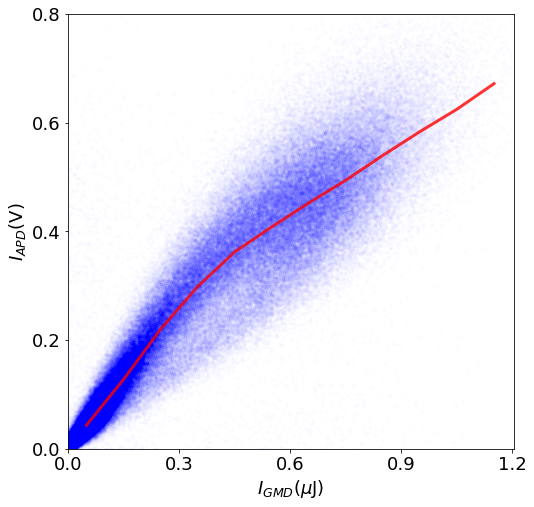

In [9]:
#this show the relationship between I and I0 is more linear after accoutning for different photon energy responses in 
#I and I0
f5, axarr5 = plt.subplots(1, sharex=True)
axarr5.plot(my_dict['GMD'],my_dict['acqiris2/amplitude'],'.',alpha=0.006,markersize=6.0)
#axarr5.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ro',alpha=50)
my_slope= theilslopes(array(acq_spectra_amplitude).transpose()[2],array(GMD_spectra_amplitude).transpose()[2],alpha=0.95)
#axarr5.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'r-',linewidth=2,alpha=50)

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=median).statistic
axarr5.plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=3,alpha=.80,c='r',linestyle='solid')

#I_FEE_hist = binned_statistic_dd(fee,y,bins=[arange(0.05,0.85,0.02)],statistic=mean).statistic
#I0_FEE_hist = binned_statistic_dd(fee,x,bins=[arange(.05,0.85,0.02)],statistic='mean').statistic
#plot(I0_FEE_hist,I_FEE_hist,marker='o',color='purple',linewidth=0)

axarr5.set_xlim(0.000,0.001205)
axarr5.set_xticks(arange(0,.001205,.0003))
axarr5.set_xticklabels(["0.0","0.3","0.6","0.9","1.2"])
axarr5.set_ylim(0,0.8)
axarr5.set_yticks(arange(0,.805,.2))
#axarr5.set_xlabel("I$_0$(mV)")
axarr5.set_xlabel(r"$I_{GMD}$($\mu$J)")
axarr5.set_ylabel("$I_{APD}$(V)")
show()

### the linearization process

In [10]:
energy_x_product = (energy-mean(energy))*(x-mean(x))
energy2_x_product = (energy-mean(energy))**2*(x-mean(x))
fee_energy_gmd_product = (fee-mean(fee))*(x-mean(x))*(energy-mean(energy))
temp_array = array([ones(len(x)),x,energy,energy_x_product]).transpose()
pseudo_inv = dot(inv(dot(temp_array.transpose(),temp_array)),array(temp_array).transpose())
beta = dot(pseudo_inv,y-mean(y))

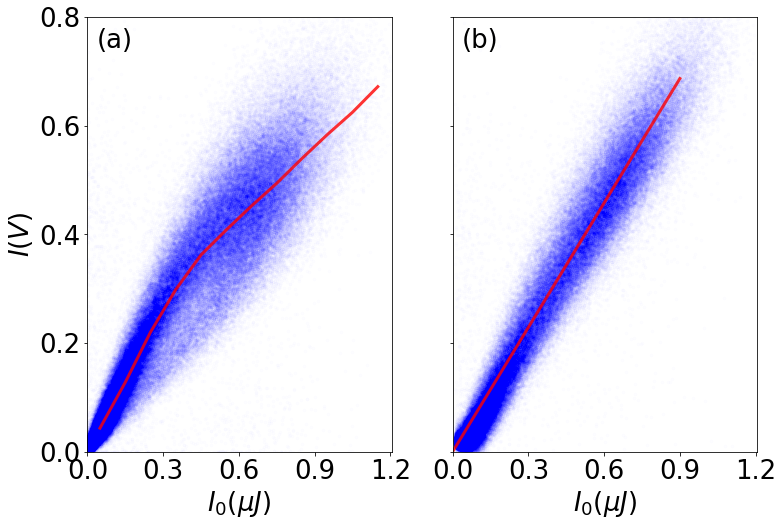

In [11]:
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 26
mpl.rcParams['legend.fontsize'] = 16
x = my_dict['GMD'][my_mask]

x_label_offset = 0.15
y_label_offset = 0.925

#y = my_dict['acqiris2/amplitude'][my_mask]
#sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
#energy = my_dict['ebeam/photon_energy'][my_mask]
#fee = my_dict['gas_detector/f_22_ENRC'][my_mask]

#y_corrected = y-dot(temp_array[:,2:],beta[2:])-temp_array[:,0]*beta[0]-mean(y)
y_corrected = y-dot(temp_array[:,2:]-mean(temp_array[:,2:],axis=0),beta[2:])

f5, axarr5 = plt.subplots(1,2,sharey=True)
axarr5[1].plot(x,y_corrected,'.',alpha=0.006,markersize=6.0)

x_linear = arange(0,0.001,0.0001)
axarr5[1].plot(x_linear,(x_linear)*beta[1],linewidth=3,alpha=.80,c='r',linestyle='solid')
axarr5[1].set_xlim(0.000,0.001205)
axarr5[1].set_ylim(0,max(y_corrected))


axarr5[0].plot(my_dict['GMD'],my_dict['acqiris2/amplitude'],'.',alpha=0.006,markersize=6.0)
#axarr5.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ro',alpha=50)
my_slope= theilslopes(array(acq_spectra_amplitude).transpose()[2],array(GMD_spectra_amplitude).transpose()[2],alpha=0.95)
#axarr5.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'r-',linewidth=2,alpha=50)

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=median).statistic
axarr5[0].plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=3,alpha=.80,c='r',linestyle='solid')
axarr5[0].text(x_label_offset, 0.975, "(a)", transform=axarr5[0].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')
axarr5[1].text(x_label_offset, 0.975, "(b)", transform=axarr5[1].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')

for i in range(2):
    axarr5[i].set_xlim(0.000,0.001205)
    axarr5[i].set_xticks(arange(0,.001205,.0003))
    axarr5[i].set_xticklabels(["0.0","0.3","0.6","0.9","1.2"])
    axarr5[i].set_xlabel(r"$I_{0}$($\mu J$)")

axarr5[0].set_ylim(0,0.8)
axarr5[0].set_yticks(arange(0,.805,.2))
#axarr5.set_xlabel("I$_0$(mV)")
axarr5[0].set_ylabel(r"$I(V)$")

show()

mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 10

### pump probe analysis using fixed gmd vs energy slope

In [12]:
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
energy = my_dict['ebeam/photon_energy'][my_mask]
fee = my_dict['gas_detector/f_22_ENRC'][my_mask]

z = my_dict['corrected_time'][my_mask]
myValues = array([x,y,z,sy,energy]).transpose()
################
################
################
#this value keeps getting tweaked. how to optimize?
bin_step=0.075

################
################
################

my_bins = arange(-6.0,35,bin_step)

In [13]:
myValues.shape

(182134, 5)

In [14]:
X_m = array([x,energy]).transpose()
dot(dot(inv(dot(X_m.transpose(),X_m)),X_m.transpose()),y)

array([  6.31924881e+02,   4.45759657e-05])

In [15]:
def get_slope(x,y,z,my_bins,i):
    try:
        temp_mask = z>my_bins[i]
        temp_mask = temp_mask *( z<my_bins[i+1])
        #print(sum(temp_mask))
        x_filtered = x[temp_mask] 
        X_m = array([x_filtered,ones(len(x_filtered))]).transpose()
        #return dot(dot(inv(dot(X_m.transpose(),X_m)),X_m.transpose()),y_corrected[temp_mask])
        temp = theilslopes(y_corrected[temp_mask],x_filtered,alpha=0.95)
        return array([i for i in temp])
    except:
        return array([0,0,0,0])
    

In [16]:
time_trace = array([get_slope(x,y_corrected,z,my_bins,i) for i in arange(len(my_bins))])

/home/sioan/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sioan/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### the pump probe trace

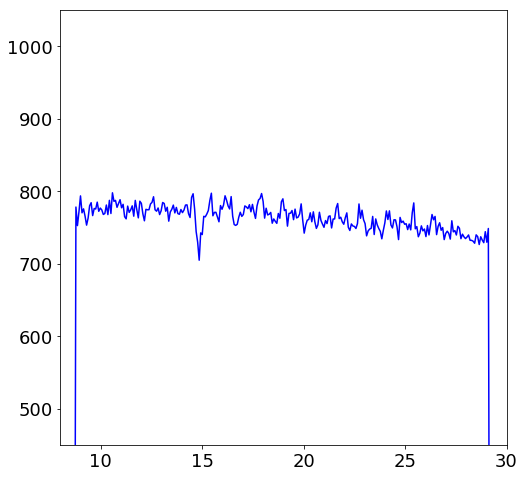

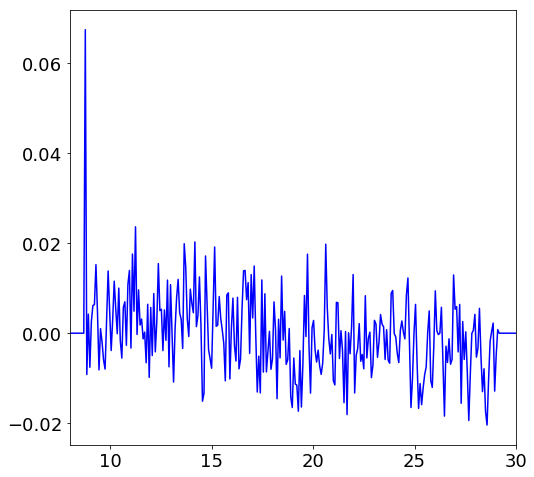

In [20]:
plot(my_bins,time_trace[:,0][::-1])
ylim(450,1050)
xlim(8,30)
show()
plot(my_bins,time_trace[:,1][::-1])
#ylim(.0014,.001)
xlim(8,30)
show()

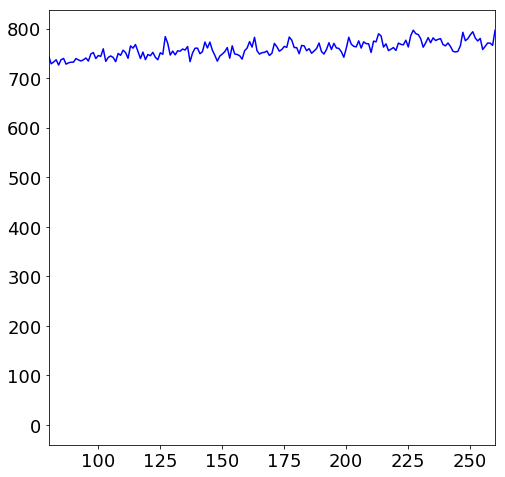

In [21]:
x_start,x_end = int(240*0.025/bin_step),int(780*0.025/bin_step)
plot(time_trace[:,0])
#ylim(850,1000)
xlim(x_start,x_end)
show()

### the confidence interval (proportional to standard deviation).  May contain interesting physics.

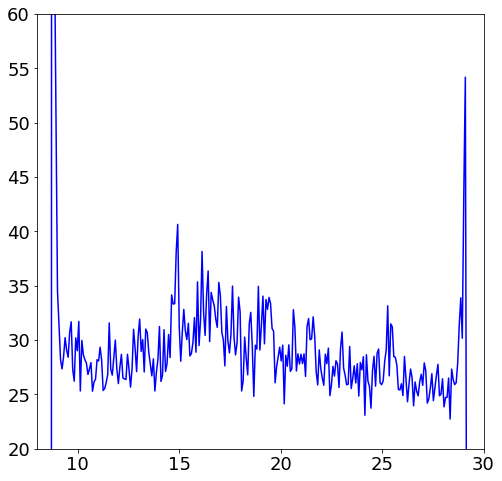

In [22]:
x_start,x_end = int(240*0.025/bin_step),int(780*0.025/bin_step)
plot(my_bins[::-1],(time_trace[:,3]-time_trace[:,2]))
#ylim(2e-2,6e-2)
xlim(8,30)
ylim(20,60)
#ylim(0,0.1)
show()

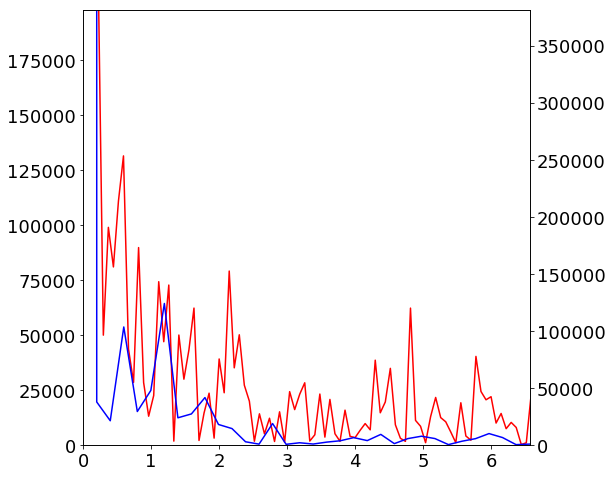

In [23]:
f = arange(len(time_trace[x_end:x_start:-1,0]))/mean(list(set(diff(my_bins))))/len(time_trace[x_end:x_start:-1,0])
my_fft  = abs(fft(time_trace[x_end:x_start:-1,0]))**2
plot(f,my_fft,'-r')
ylim(0,sort(my_fft)[-12]*2)
#xlim(0,7)

twinx()
temp_mask = my_bins<14.5
temp_mask = temp_mask*my_bins>9.5

f = arange(len(time_trace[temp_mask,0][::-1]))/mean(list(set(diff(my_bins))))/len(time_trace[temp_mask,0][::-1])
my_fft  = abs(fft(time_trace[temp_mask,0][::-1]))**2
plot(f,my_fft)
ylim(0,sort(my_fft)[-7]*8)
xlim(0,max(f)/2)


show()


## fitting apd vs both energy and gmd using RANSAC

In [24]:
X_m = array([x,energy,(x-mean(x))*(energy-mean(energy))]).transpose()

In [25]:
X_m.shape

(182134, 3)

In [26]:
ransac = linear_model.RANSACRegressor()
ransac.fit(rand(100,2),rand(100))

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_trials=100, min_samples=None,
        random_state=None, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [27]:
def get_ransac(i):
    try:
        temp_mask = z>my_bins[i]
        temp_mask = temp_mask*(z<my_bins[i+1])
        ransac = linear_model.RANSACRegressor(max_trials=1000)
        ransac.fit(X_m[temp_mask],y[temp_mask])
    except:
        ransac.fit(rand(100,3),rand(100))

    return ransac

In [28]:
pump_probe_trace = array([get_ransac(i) for i in arange(len(my_bins)-1)])
pump_probe_trace_coef = array([pump_probe_trace[i].estimator_.coef_ for i in arange(len(pump_probe_trace))])

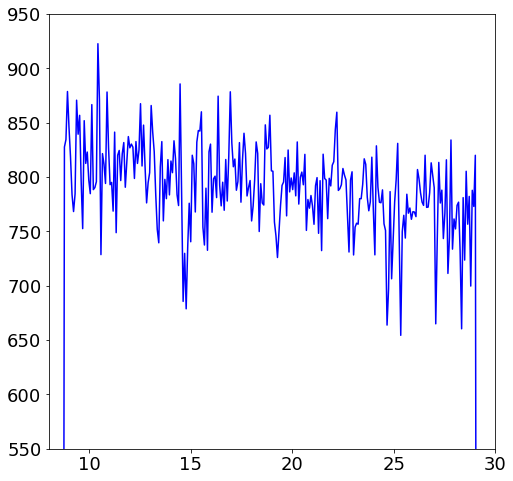

In [30]:
plot(my_bins[:-1][::-1],pump_probe_trace_coef[:,0])
xlim(8,30)
ylim(550,950)
show()

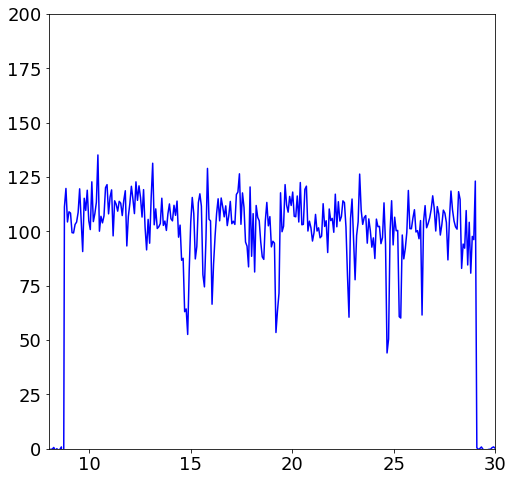

In [31]:
plot(my_bins[:-1][::-1],pump_probe_trace_coef[:,2])
xlim(8,30)
ylim(0,200)
show()

## fitting apd vs both energy and gmd using multi-dimensional theil-sen 

In [32]:
def get_theilsen(i):
    try:
        temp_mask = z>my_bins[i]
        temp_mask = temp_mask*(z<my_bins[i+1])
        estimator =  TheilSenRegressor()
        estimator.fit(X_m[temp_mask],y[temp_mask])
    except:
        estimator.fit(rand(100,3),rand(100))

    return estimator

In [33]:
pump_probe_trace = array([get_theilsen(i) for i in arange(len(my_bins)-1)])

In [34]:
pump_probe_trace_coef = array([pump_probe_trace[i].coef_ for i in arange(len(pump_probe_trace))])

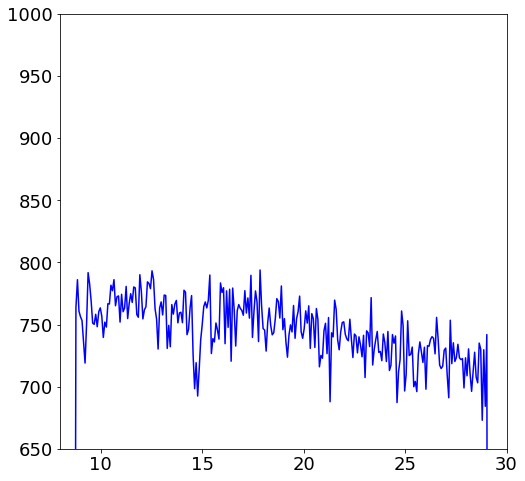

In [40]:
plot(my_bins[:-1][::-1],pump_probe_trace_coef[:,0])
xlim(8,30)
ylim(650,1000)
show()

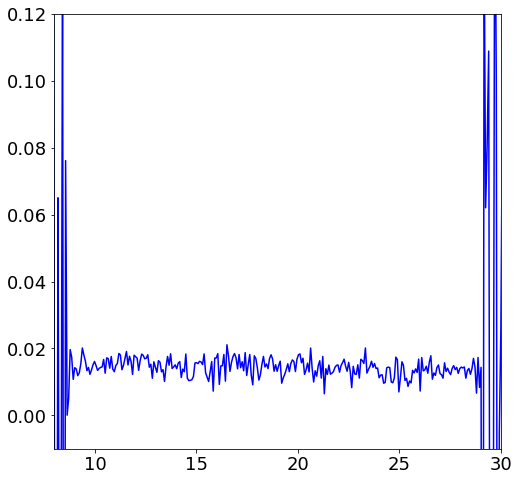

In [42]:
plot(my_bins[:-1][::-1],pump_probe_trace_coef[:,1])
xlim(8,30)
ylim(-0.01,0.12)
show()

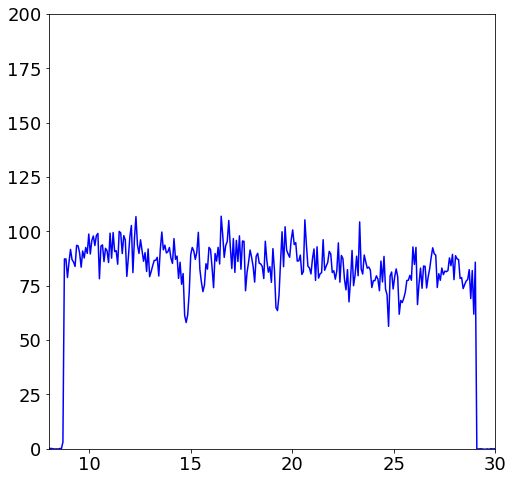

In [44]:
plot(my_bins[:-1][::-1],pump_probe_trace_coef[:,2])
xlim(8,30)
ylim(0,200)
show()

In [38]:
intercepts = array([pump_probe_trace[i].intercept_ for i in arange(len(pump_probe_trace))])

In [39]:
temp.tol

NameError: name 'temp' is not defined

In [ ]:
plot(my_bins[:-1][::-1],intercepts)
xlim(8,30)
#ylim(-0.01,0.02)
show()